In [1]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time


In [2]:
import decoupler as dc
import pandas as pd
import sys
import pickle
import tqdm
import scipy
import anndata

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
inference = DefaultInference(n_cpus=8)

In [3]:
import pickle
with open('/home/ec2-user/curation/heart_datasets/gg_250327_heart_data_split_by_xist.p', 'rb') as fp:
    ads = pickle.load( fp)


# DE

In [4]:
def build_consensus_ad(ads,filter_by = 'xist'):
    consensus_genes = set(ads[list(ads.keys())[0]].var_names)
    for i,dataset in enumerate(ads.keys()):
        consensus_genes = consensus_genes&set(ads[dataset].var_names)
        
    ads_filt = {}
    for i,dataset in enumerate(ads.keys()):
        ads_filt[dataset] = ads[dataset][:,list(consensus_genes)].copy()
        ads_filt[dataset].obs['dataset'] = dataset
    
        if 'age' in ads_filt[dataset].obs.columns:
            pass
        elif 'Age_bin' in ads_filt[dataset].obs.columns:
            x1 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[1].astype(float)
            x2 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[0].astype(float)
            x = (x1+x2)/2
            ads_filt[dataset].obs['age'] = x
    ad=anndata.concat([ads_filt[x] for x in ads_filt.keys()])
    if filter_by=='xist':
        ad.obs['donor_id'] = ad.obs['donor_id']+'_'+ad.obs['dataset']
        ad.obs_names_make_unique()
        return ad

In [5]:
ad=build_consensus_ad(ads)

/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)

In [11]:
ad.obs

,donor_id,xist,sex,age,psbulk_n_cells,psbulk_counts,dataset
TWCM-190-R-post_absent,TWCM-190-R-post_amrute,absent,male,18,6.0,7190.0,amrute
TWCM-190-R-pre_absent,TWCM-190-R-pre_amrute,absent,male,18,64.0,98084.0,amrute
TWCM-229-R-post_absent,TWCM-229-R-post_amrute,absent,male,60,9.0,12746.0,amrute
TWCM-229-R-pre_absent,TWCM-229-R-pre_amrute,absent,male,60,5.0,8032.0,amrute
TWCM-239-R-post_absent,TWCM-239-R-post_amrute,absent,male,44,7.0,10203.0,amrute
...,...,...,...,...,...,...,...
1600_present,1600_tucker,present,female,51,89.0,128194.0,tucker
1666_present,1666_tucker,present,male,54,43.0,45612.0,tucker
1681_present,1681_tucker,present,male,39,96.0,127180.0,tucker
1708_present,1708_tucker,present,female,60,62.0,68904.0,tucker


In [12]:
t1=time.time()
ad_ = ad[ad.obs['sex'] =='female'].copy() #get female donors
vc = ad_.obs['donor_id'].value_counts()
vc = vc[vc==2] #filter for those with XIST+ and XIST- cells
ad_f = ad_[ad_.obs['donor_id'].isin(vc.index)]

In [20]:
dds_f = DeseqDataSet(
    adata=ad_f.copy(),
    design_factors=['xist','donor_id'],
    refit_cooks=True,
    inference=inference,
    quiet=False)


/tmp/ipykernel_9442/4060663907.py:1: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds_f = DeseqDataSet(
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [21]:
dds_f.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 112.47 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 101.79 seconds.

Fitting LFCs...
... done in 4.12 seconds.

Replacing 0 outlier genes.



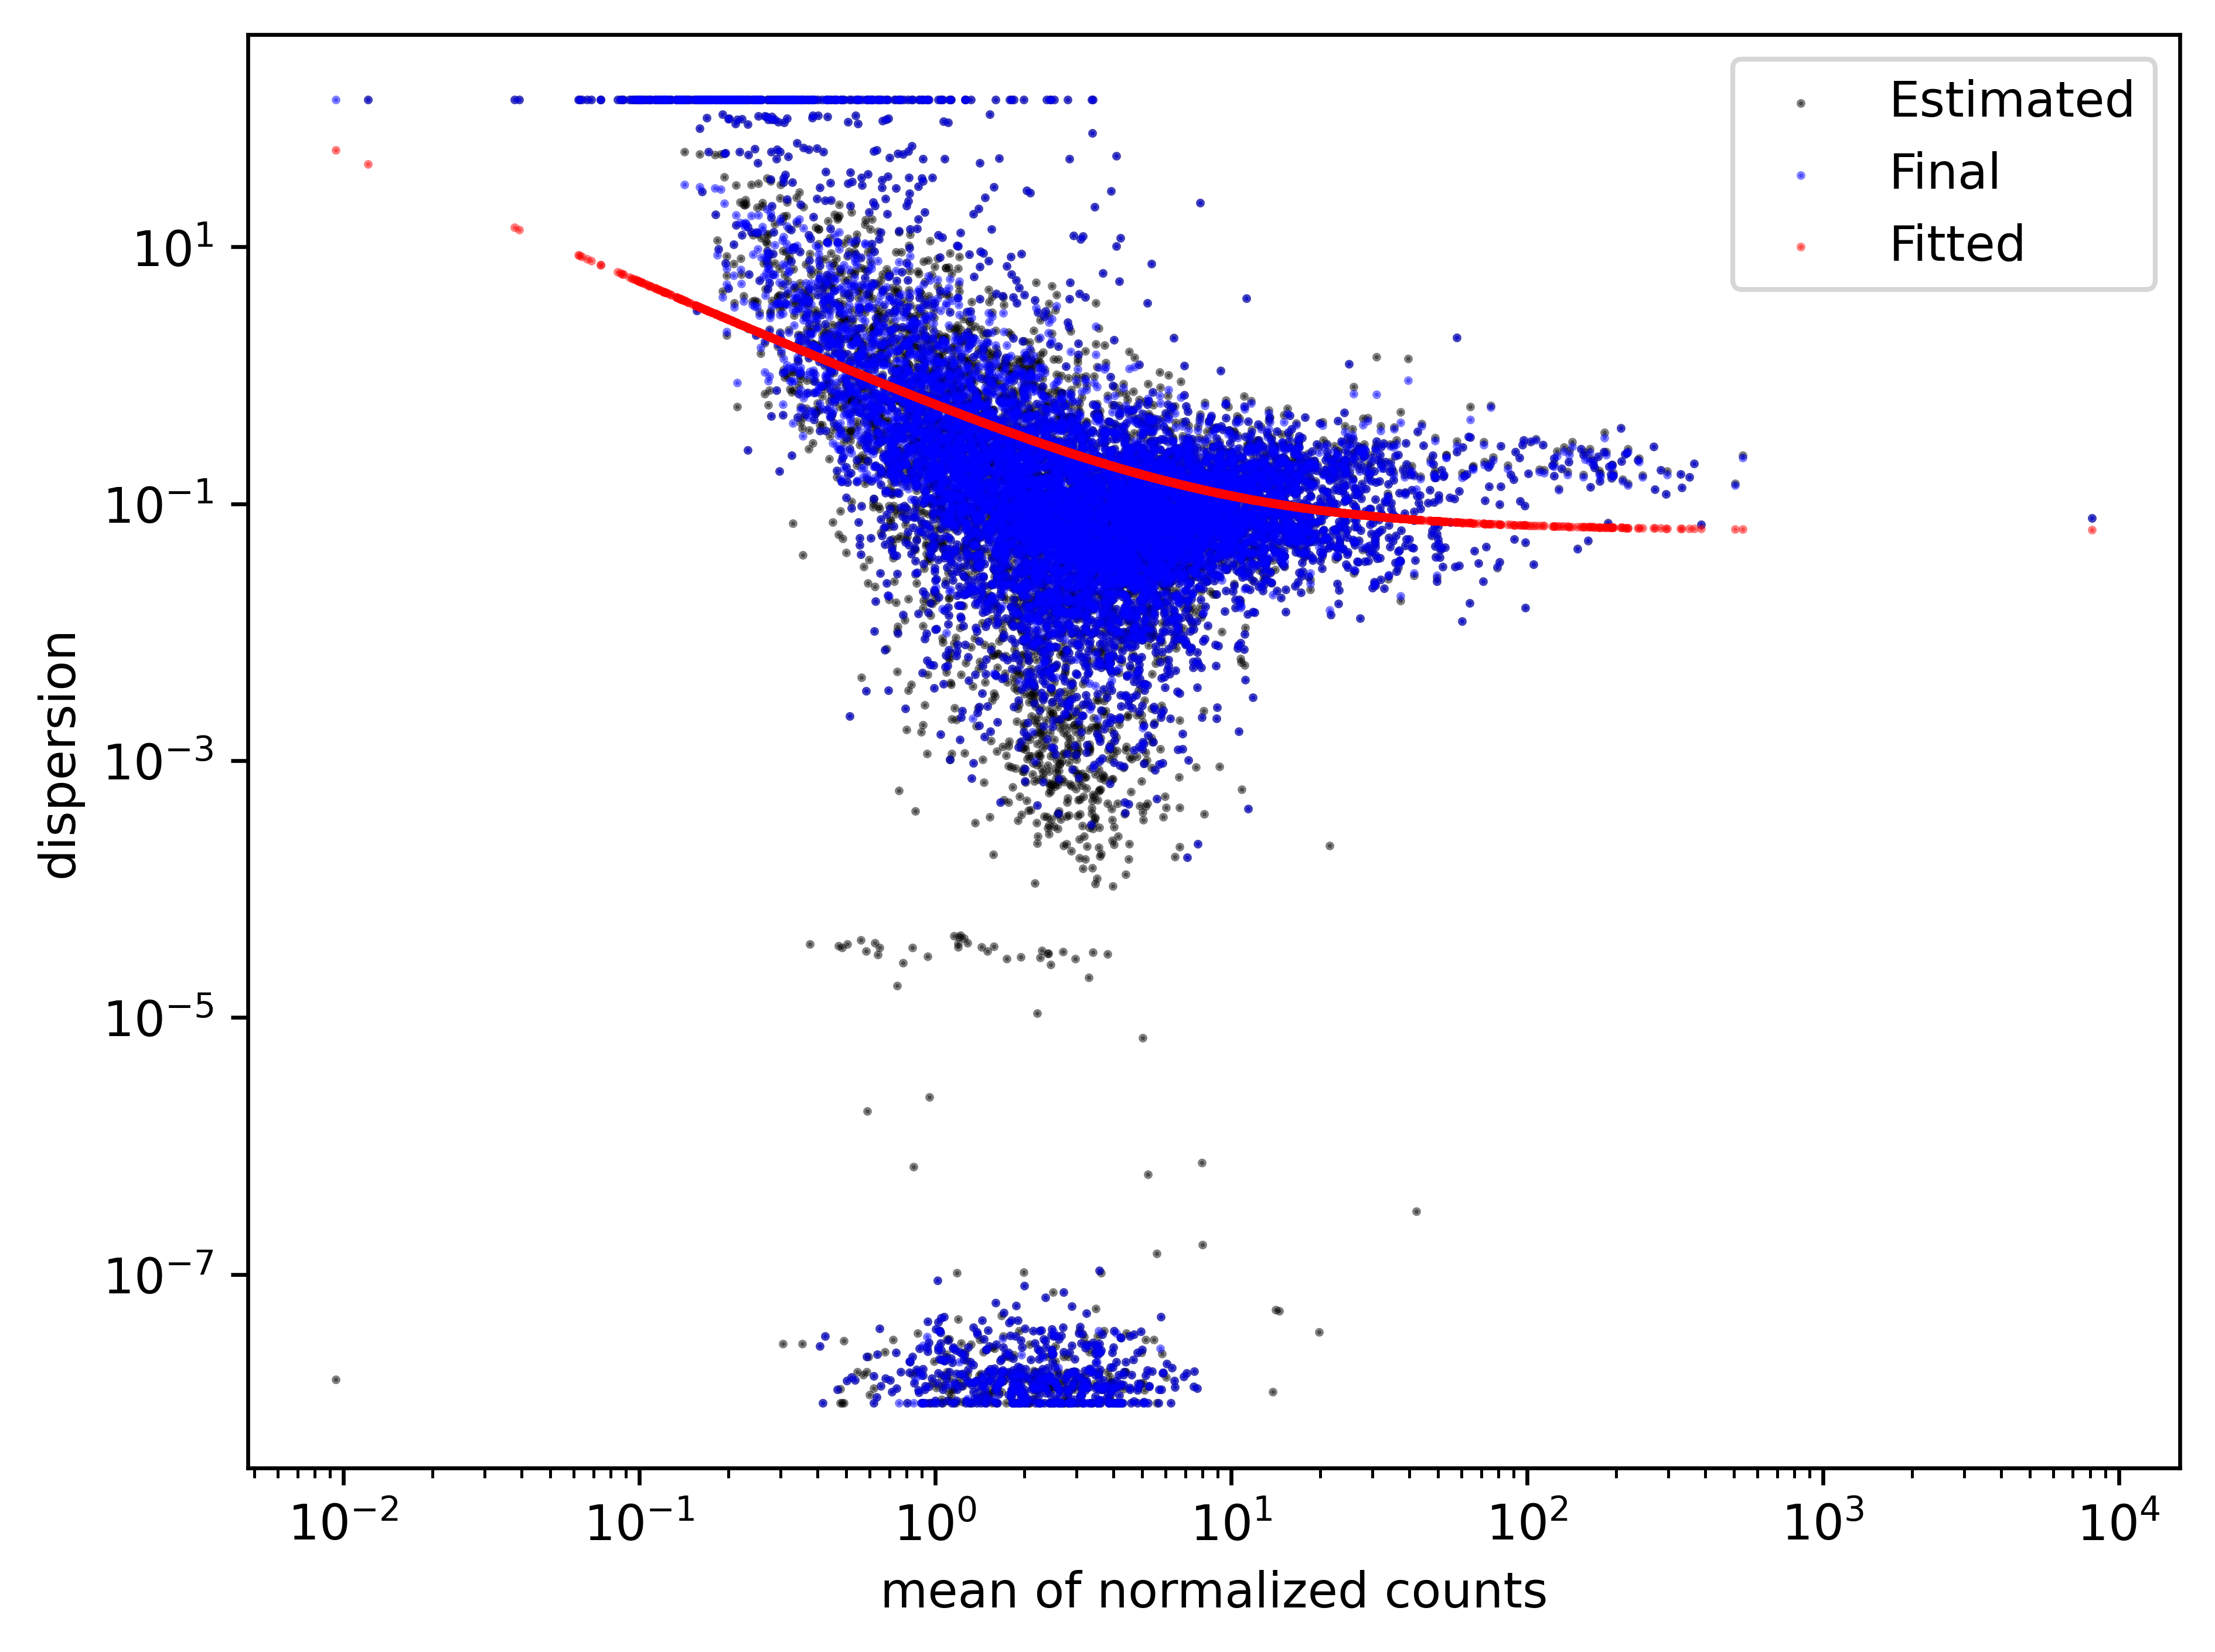

In [22]:
dds_f.plot_dispersions()

In [23]:

stat_res_Y_vs_X = DeseqStats(dds_f, contrast=["xist", "present", "absent"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res_f = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)

res_f['chr'] = res_f.index.map(dict_ensembl)
res_f.to_csv('/home/ec2-user/curation/heart_datasets/deseq/gg_250328_xist_pres_vs_abs_donor_id_2samp_female.csv')
with open('/home/ec2-user/curation/heart_datasets/gg_250328_female_glia_deseq.anndata.p', 'wb') as fp:
    pickle.dump(dds_f,fp)
t2=time.time()
print('Runtime: {:.2f} minutes.'.format((t2-t1)/60))

Log2 fold change & Wald test p-value: xist present vs absent
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
MEG3     76.932381        0.360598  0.186657  1.931879  0.053375  0.272833
ACSL5     0.424299       -0.945903  0.552081 -1.713342  0.086650       NaN
KCTD3     7.663368       -0.056322  0.115149 -0.489120  0.624757  0.840232
TMEM39B   1.014292       -0.528385  0.262850 -2.010216  0.044408       NaN
TTC13     1.507643        0.194819  0.158245  1.231125  0.218276  0.522731
...            ...             ...       ...       ...       ...       ...
GTF2A1    2.637269       -0.170604  0.178210 -0.957316  0.338408  0.630450
TMEM33    3.394428        0.209223  0.183753  1.138608  0.254866  0.557989
POLR2D    2.230886       -0.553400  0.280245 -1.974700  0.048302  0.260514
CCDC90B   6.733711       -0.360023  0.202865 -1.774697  0.075948  0.318991
THEMIS2   0.160266       -1.839111  2.932055 -0.627243  0.530500       NaN

[10391 rows x 6 columns]
Runtime: 7.07

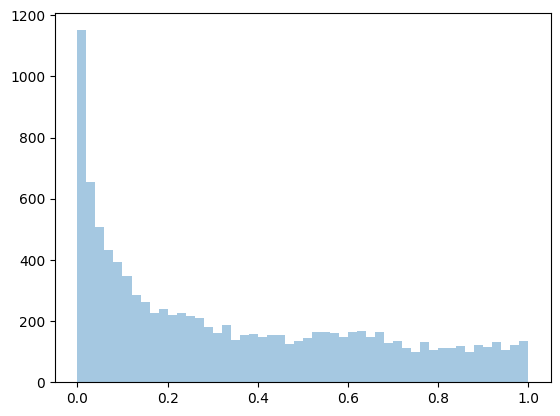

In [24]:
plt.hist(res_f['pvalue'],50,alpha=0.4)
plt.show()

In [25]:
len(res_f[(res_f['baseMean']>5)&(res_f['padj']<0.05)].sort_values('padj'))

36

(-1.0, 10.0)

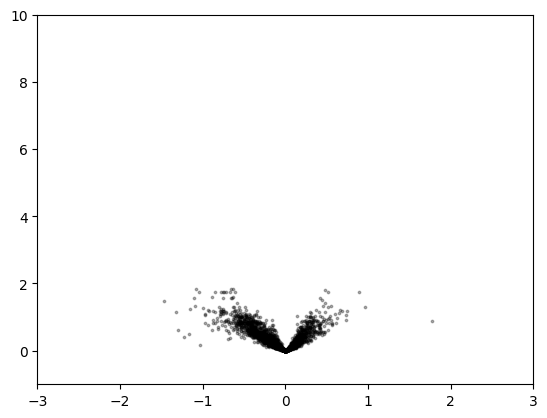

In [26]:
gf = res_f['baseMean']>5
plt.scatter(res_f.loc[gf,'log2FoldChange'],-np.log10(res_f.loc[gf,'padj']),3,'k',alpha=0.3)
plt.xlim([-3,3])
plt.ylim([-1,10])

In [29]:
t1=time.time()
ad_ = ad[ad.obs['sex'] =='male'].copy() #get male donors
vc = ad_.obs['donor_id'].value_counts()
vc = vc[vc==2] #filter for those with XIST+ and XIST- cells
ad_m = ad_[ad_.obs['donor_id'].isin(vc.index)]
dds_m = DeseqDataSet(
    adata=ad_m.copy(),
    design_factors=['donor_id','xist'],
    refit_cooks=True,
    inference=inference,
    quiet=False)

/tmp/ipykernel_9442/4202106666.py:6: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds_m = DeseqDataSet(
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:262: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [30]:
dds_m.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 3865.29 seconds.

Fitting LFCs...
... done in 32.65 seconds.

Replacing 0 outlier genes.



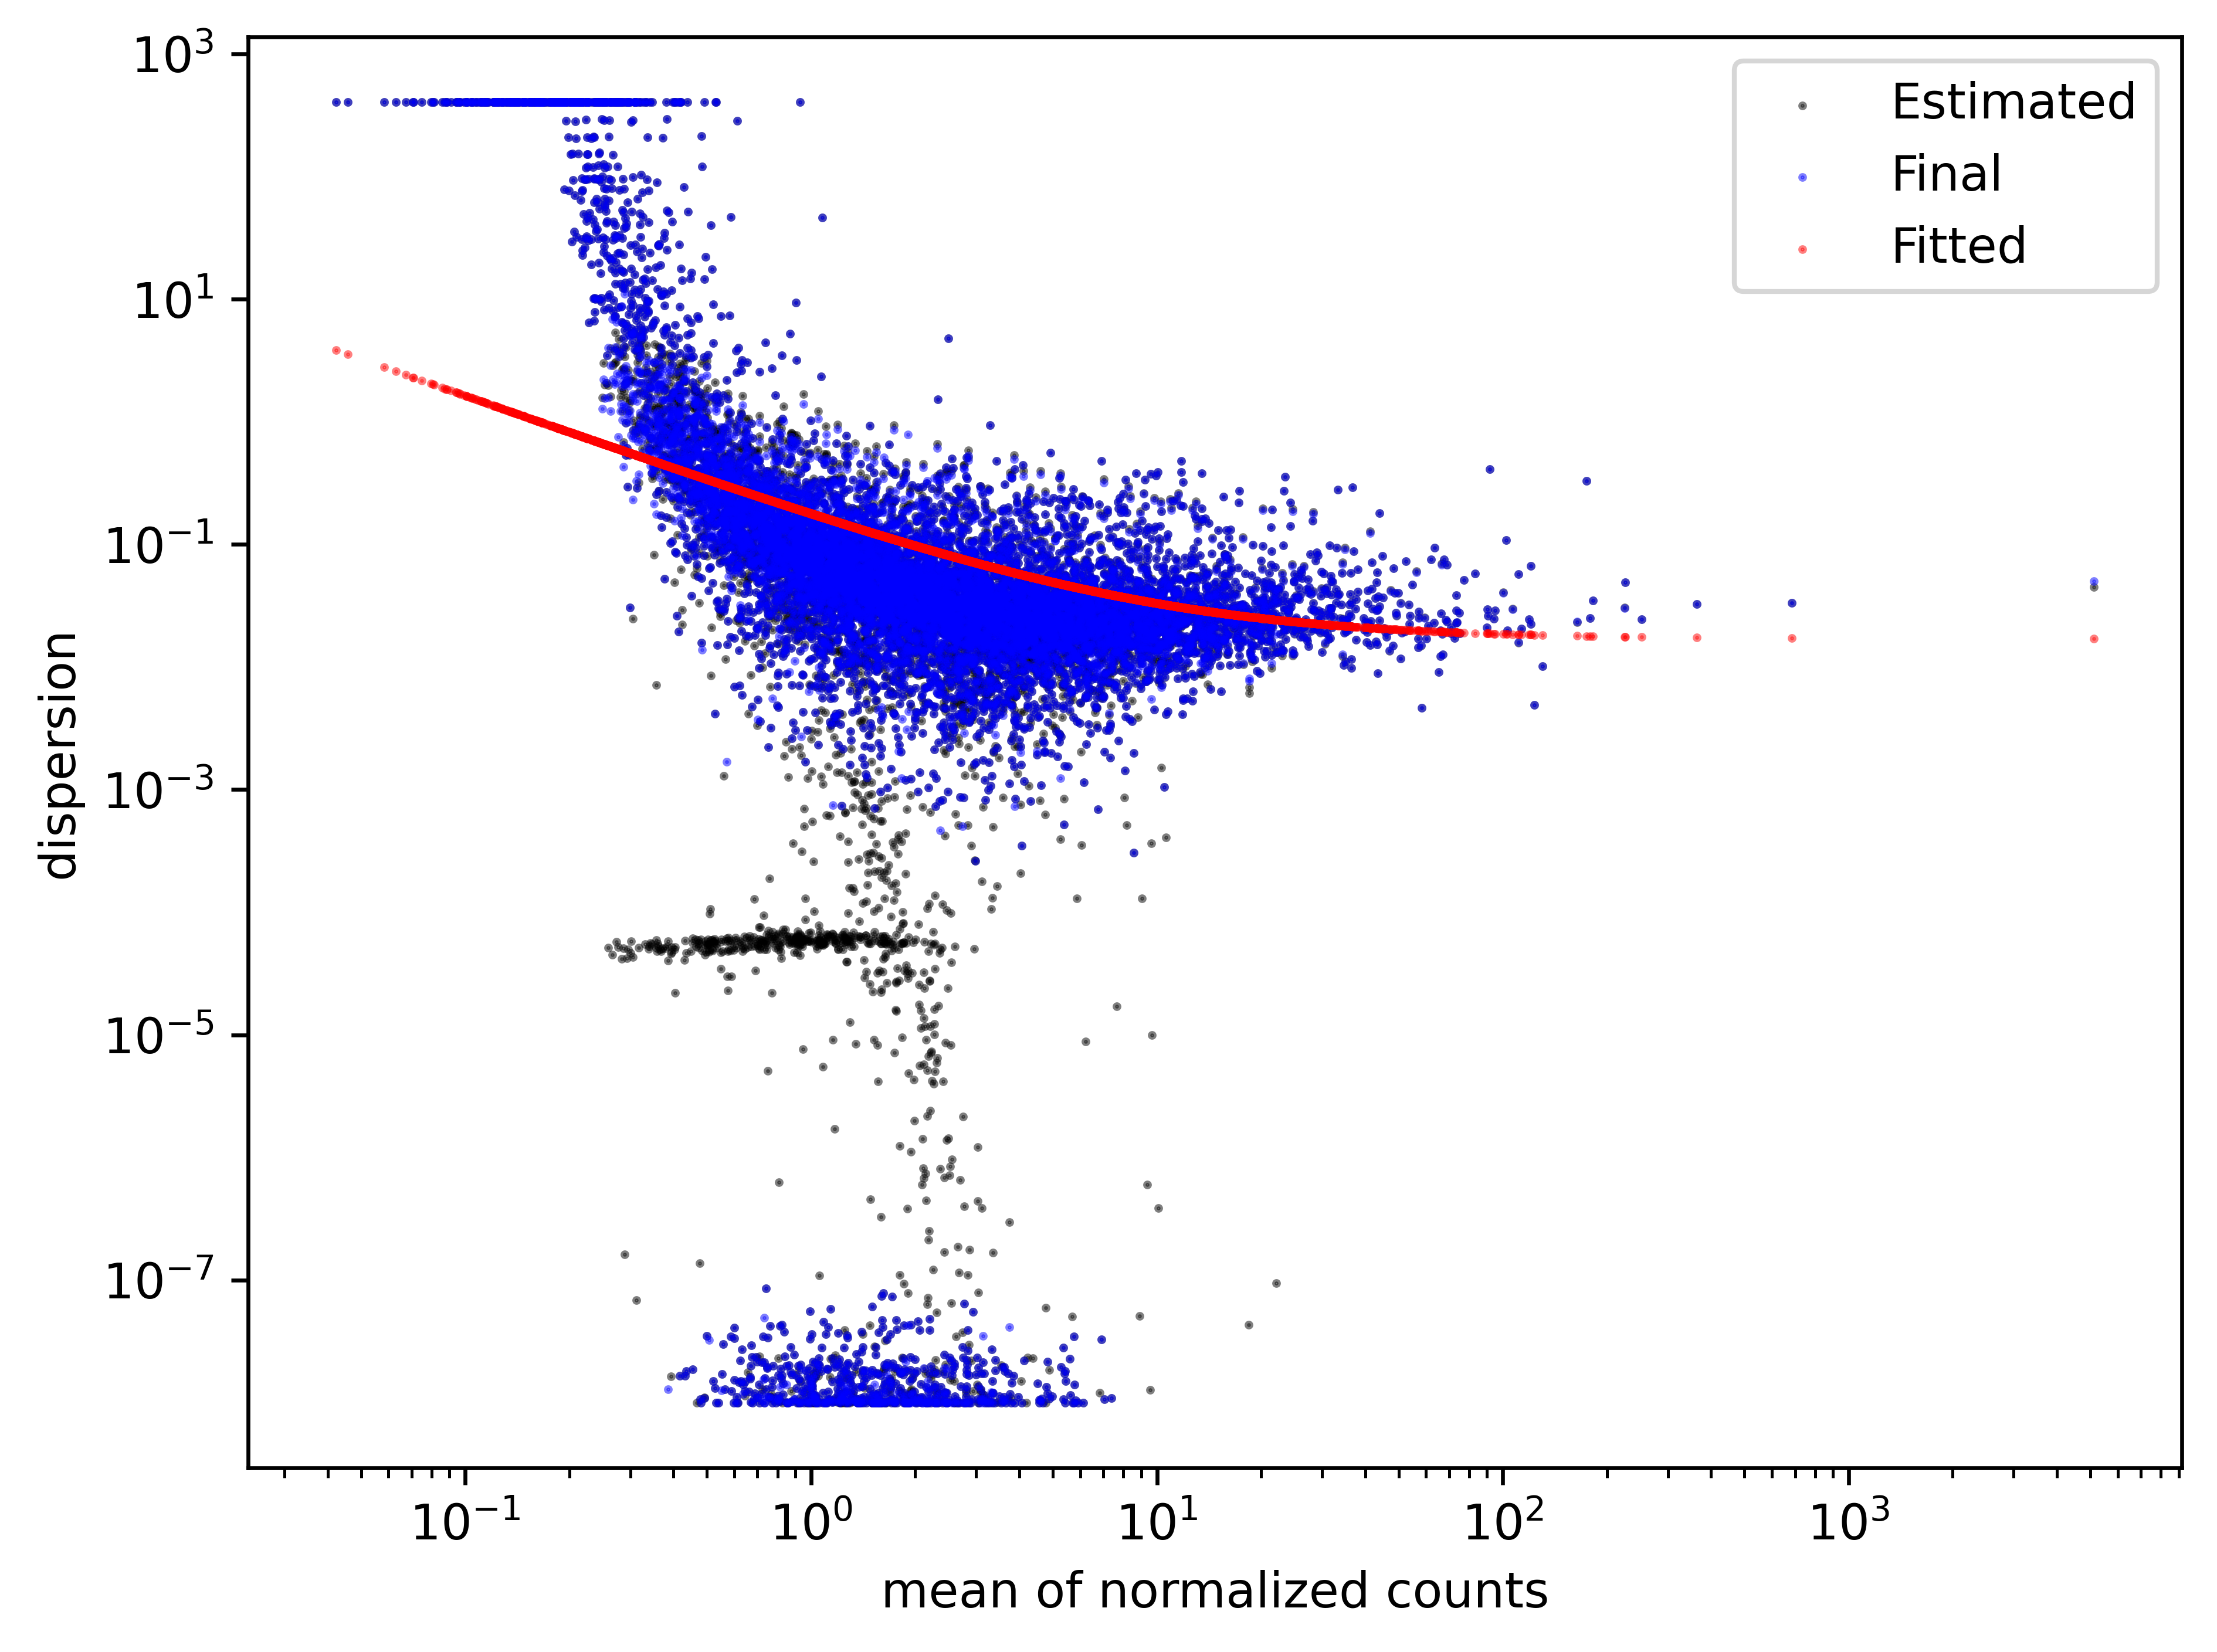

In [ ]:
dds_m.plot_dispersions()

In [ ]:
stat_res_Y_vs_X = DeseqStats(dds_m, contrast=["xist", "present", "absent"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res_m = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)

res_m['chr'] = res_m.index.map(dict_ensembl)
res_m.to_csv('/home/ec2-user/curation/heart_datasets/deseq/gg_250328_xist_pres_vs_abs_donor_id_2samp_male.csv')
with open('/home/ec2-user/curation/heart_datasets/gg_250328_male_glia_deseq.anndata.p', 'wb') as fp:
    pickle.dump(dds_m,fp)
t2=time.time()
print('Runtime: {:.2f} minutes.'.format((t2-t1)/60))

Log2 fold change & Wald test p-value: xist present vs absent
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
MEG3      5.273355       -0.314443  0.096384 -3.262403  0.001105  0.010512
ACSL5     0.362777        0.199098  0.197191  1.009670  0.312653       NaN
KCTD3    10.165855        0.040441  0.044983  0.899025  0.368639  0.538371
TMEM39B   0.611069       -0.096929  0.184368 -0.525735  0.599072       NaN
TTC13     2.482397       -0.063596  0.078941 -0.805613  0.420466  0.587815
...            ...             ...       ...       ...       ...       ...
GTF2A1    2.230806       -0.137206  0.087492 -1.568203  0.116834  0.253147
TMEM33    1.739723        0.050036  0.097662  0.512339  0.608414  0.737224
POLR2D    0.719971        0.113270  0.152439  0.743056  0.457448       NaN
CCDC90B   1.478119       -0.063513  0.088494 -0.717709  0.472937       NaN
THEMIS2   0.342374        0.306170  2.901316  0.105528  0.915957       NaN

[10391 rows x 6 columns]
Runtime: 140.

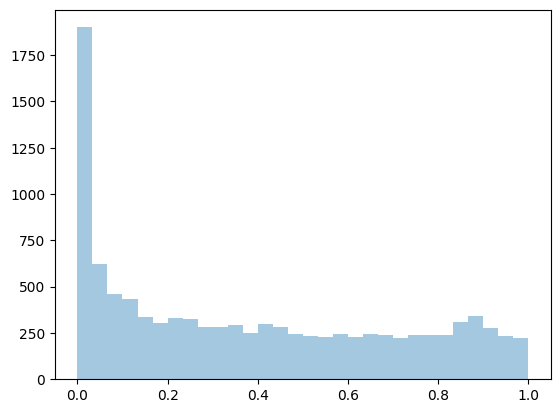

In [ ]:
plt.hist(res_m['pvalue'],30,alpha=0.4)
plt.show()

(-1.0, 10.0)

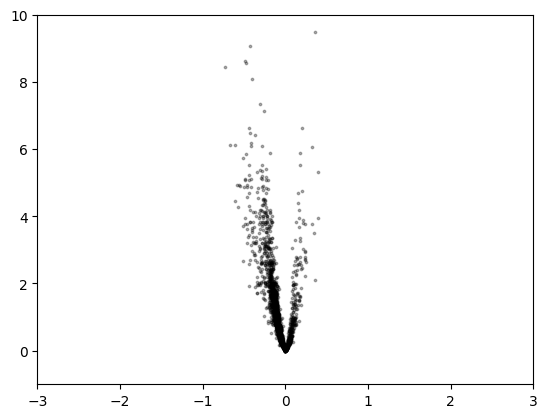

In [ ]:
gf = res_m['baseMean']>5
plt.scatter(res_m.loc[gf,'log2FoldChange'],-np.log10(res_m.loc[gf,'padj']),3,'k',alpha=0.3)
plt.xlim([-3,3])
plt.ylim([-1,10])